A summary of the Retweet, Reply, only descriptive statistics, using the function written for Task 1.2 in the first of the two labs).

Task 1.2: produce a descriptive summary of the two networks, choosing the whole-network measures that you find useful to report, but including at least: order, size, number of components, density, clustering coefficient / transitivity, and a plot of the degree distribution.

TIPS:

you will have to produce such a summary multiple times, to compare different graphs. So consider writing a function taking a network as input and producing the summary.
for the plot with the degree distribution, consider using log-log axes.

In [45]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
from matplotlib import cm, colors
ig.config["plotting.backend"] = "matplotlib"

def graph_stats(G):
    order = G.vcount()
    size = G.ecount()
    components = len(G.connected_components())
    density = G.density()
    clustering_coefficient = G.transitivity_undirected()
    degrees = G.degree()
    
    clustering_coefficients = G.transitivity_local_undirected()
    betweenness_centrality = G.betweenness()

    print(f"Order (number of nodes): {order}")
    print(f"Size (number of edges): {size}")
    print(f"Number of components: {components}")
    print(f"Density: {density:.3f}")
    print(f"Clustering coefficient / Transitivity: {clustering_coefficient:.3f}")
    
    avg_clustering = np.mean([c for c in clustering_coefficients if not np.isnan(c)])
    print(f"Average Clustering Coefficient: {avg_clustering:.3f}")
    
    min_degree = min(degrees)
    max_degree = max(degrees)
    bins = np.logspace(np.log10(min_degree if min_degree > 0 else 1), 
                       np.log10(max_degree + 1), 10, base=10)

    plt.figure(figsize=(20, 10))
    plt.title("Degree Distribution (Logarithmic Binning)")
    plt.hist(degrees, bins=bins, align='mid', rwidth=0.8, color='skyblue', density=True)
    plt.xscale('log'), plt.yscale('log')
    plt.xlabel("Degree (log scale)")
    plt.ylabel("Probability (log scale)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

def create_retweet_graph(tweets):
    edges = []
    all_users = set()
    for tweet in tweets:
        author_id = tweet['author_id']
        all_users.add(author_id)
        if 'referenced_tweets' in tweet:
            for ref_tweet in tweet['referenced_tweets']:
                if ref_tweet['type'] == 'retweeted':
                    if 'entities' in tweet and 'mentions' in tweet['entities']:
                        for mention in tweet['entities']['mentions']:
                            edges.append((author_id, mention['id']))
                            all_users.add(mention['id'])
                            break
    
    G = ig.Graph(directed=True)
    G.add_vertices(list(all_users))
    G.add_edges(edges)
    return G

def create_reply_graph(tweets):
    conversation_to_author = {}
    edges = []
    for tweet in tweets:
        conversation_to_author[tweet["conversation_id"]] = tweet["author_id"]
        if tweet["conversation_id"] != tweet["id"]:
            source_author = tweet["author_id"]  # Current user (the one replying)
            target_author = conversation_to_author.get(tweet["conversation_id"])  # Original author
            if target_author:  # Ensure we have the target author
                edges.append((source_author, target_author))
    
    G = ig.Graph(directed=True)
    unique_users = set([edge[0] for edge in edges] + [edge[1] for edge in edges])
    G.add_vertices(list(unique_users))
    G.add_edges(edges)
    return G

def remove_isolated_vertices(G, min_degree=1, min_betweenness=0):
    degrees = G.degree()
    betweenness = G.betweenness()
    nodes_to_keep = [
        vertex.index for vertex in G.vs if degrees[vertex.index] >= min_degree 
        and betweenness[vertex.index] >= min_betweenness
    ]
    subgraph = G.induced_subgraph(nodes_to_keep, implementation="create_from_scratch")
    subgraph_degrees = subgraph.degree()
    subgraph_betweenness = subgraph.betweenness()
    nodes_to_keep_in_subgraph = [
        vertex.index for vertex in subgraph.vs if subgraph_degrees[vertex.index] >= min_degree 
        and subgraph_betweenness[vertex.index] >= min_betweenness
    ]
    g = subgraph.induced_subgraph(nodes_to_keep_in_subgraph, implementation="create_from_scratch")
    return g


### Can't load this because the file is too big ###
    
#with open("active_user_graph.json", "r") as json_file:
#    tweets = json.load(json_file)

# Creating the graphs
#G_reply = create_reply_graph(tweets)
#G_retweet = create_retweet_graph(tweets)

# Filtering out isolated vertices
#g_reply = remove_isolated_vertices(G_reply)
#g_retweet = remove_isolated_vertices(G_retweet, min_betweenness=1e-7) # Removes users with 0 betweenness
#g_reply.write("filtered_reply_network.pickle", format="pickle")
#g_retweet.write("filtered_retweet_network.pickle", format="pickle")

Order (number of nodes): 247
Size (number of edges): 2980
Number of components: 244
Density: 0.049
Clustering coefficient / Transitivity: 0.002
Average Clustering Coefficient: 0.042


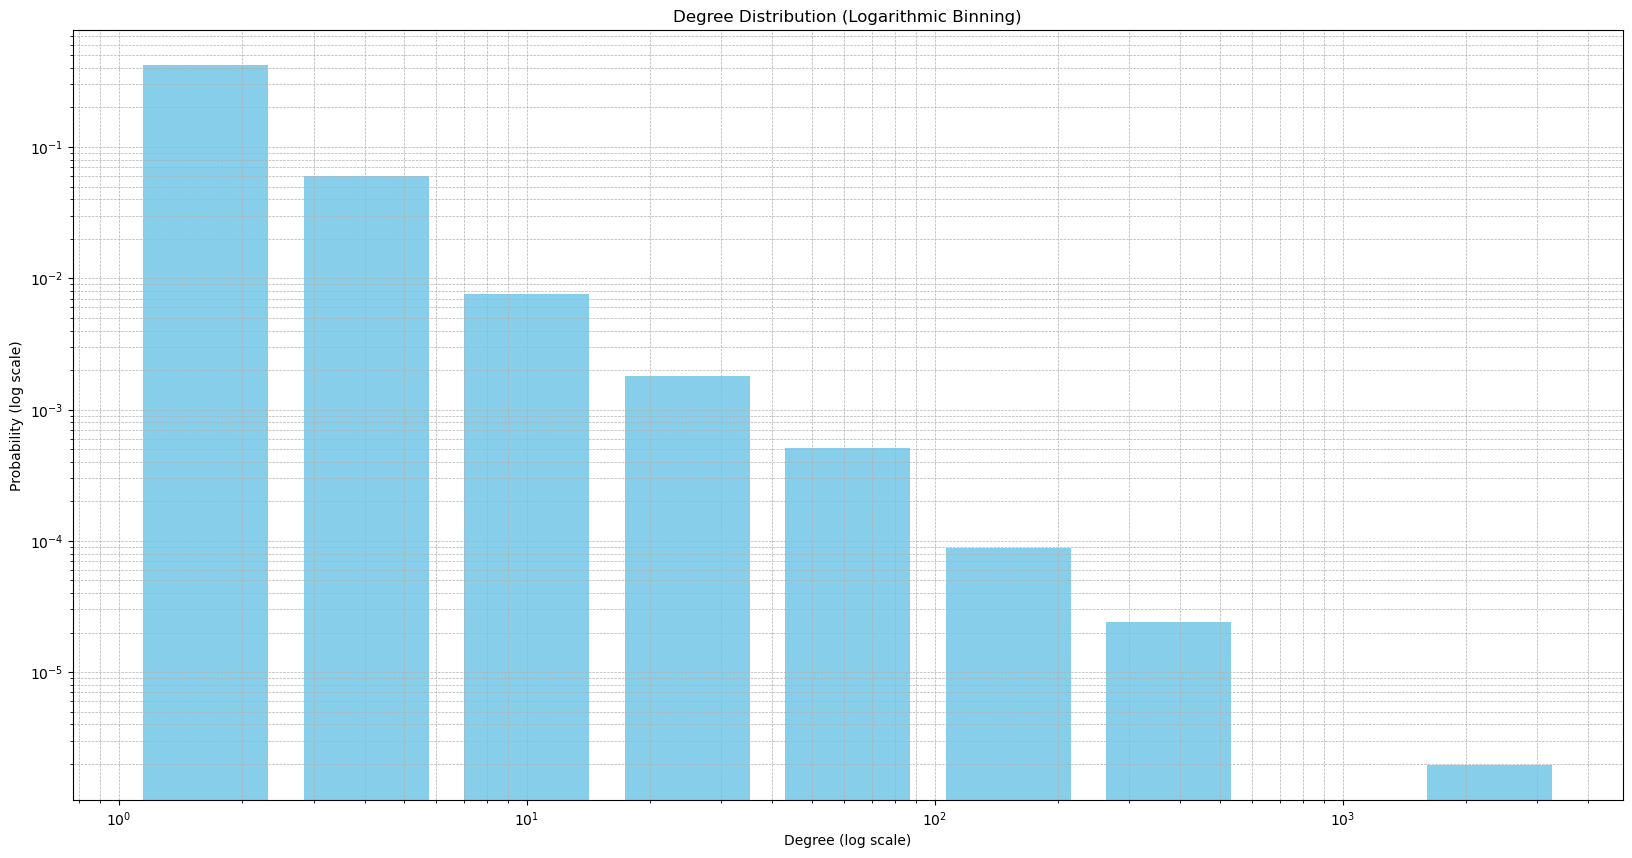

In [47]:
g = ig.Graph.Read("filtered_reply_network.pickle", format="pickle")
graph_stats(g)
plt.savefig("reply_network_degree_distribution.png", bbox_inches="tight")

Order (number of nodes): 419
Size (number of edges): 11966
Number of components: 22
Density: 0.068
Clustering coefficient / Transitivity: 0.164
Average Clustering Coefficient: 0.328


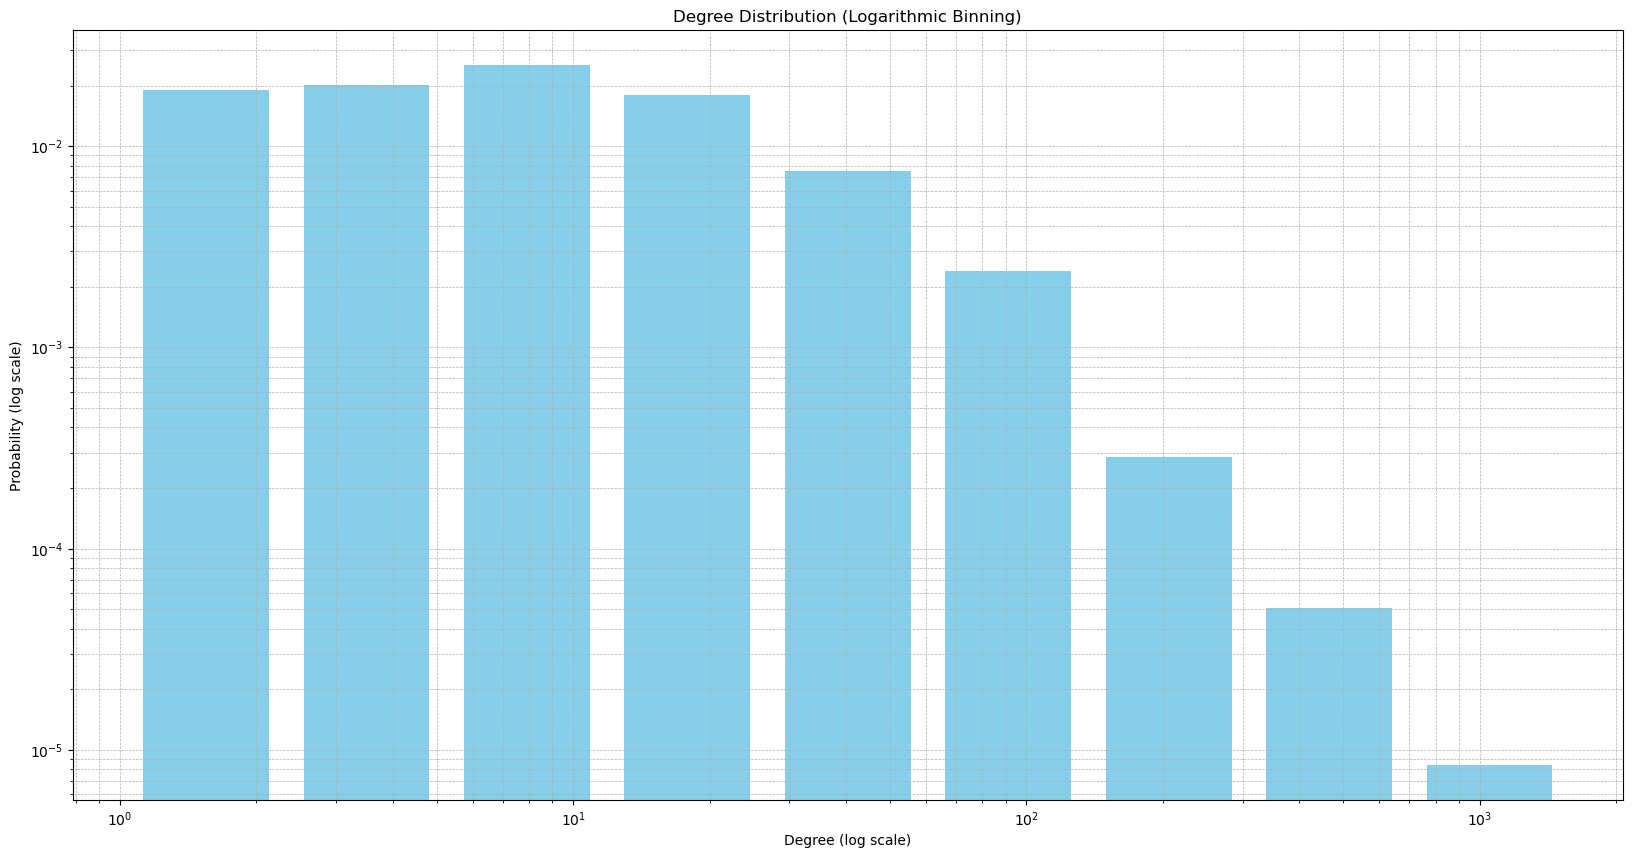

In [49]:
g = ig.Graph.Read("filtered_retweet_network.pickle", format="pickle")
graph_stats(g)
plt.savefig("retweet_network_degree_distribution.png", bbox_inches="tight")

## TODO
1. Do the same thing for ER.
2. Do the same thing for BA.
3. Do the same thing for SW.